In [302]:
!explorer.exe .

In [37]:
import requests
import urllib
from bs4 import BeautifulSoup
import itertools
import collections
import re
import pickle

import networkx as nx
import matplotlib.pyplot as plt

In [174]:
artists = {}
for i in range(12):
    url = 'https://musicbrainz.org/tag/country/artist?page=' + str(i)
    page = requests.get(url)

    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find(id='content')
    ul = results.contents[5]
    li = ul.find_all('li')
    for l in li:
        line = l.find('a')
        id = line.attrs['href'].split('/')[2]
        name = line.text
        artists[name]=id

In [3]:
# recursive function to grab the underlying html text of a webpage
def grab_url_text(theurl,remaining_tries=5):
    # These headers help to make the computer look like a legitimate web browser and not a bot
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    
    print('Analyzing: '+theurl+' ... ',end='')
    try:
        # these lines are the meat of the program - they grab the underlying html textfile that describes the webpage
        r = urllib.request.Request(theurl,data=None,headers=headers)
        f = urllib.request.urlopen(r)
        s = f.read()
        s = s.decode('utf-8') # the string enters as a byte string which needs to be decoded into a useful string format UTF-8
        f.close()
        print('done!')
        return s
    except: # if there is a problem, print the error and try again
        print('\n\t!!! Connection Issue')
        if remaining_tries > 0:
            time.sleep(2)
            grab_url_text(theurl,remaining_tries-1)
        else:
            raise

In [4]:
def get_credit_html(html):
    table = html.split('<select style="max-width:40em" class="with-button" id="id-filter.artist_credit_id" name="filter.artist_credit_id">')[1]
    table = table.split('</select>')[0]
    return table

In [5]:
def parse_table(table):
    credits = []
    for line in table.split('<option')[2:]:
        credit = line.split('">')[1]
        credit = credit.split('</option>')[0]
        credits.append(credit)
    return credits

## Get list of top genres to pull artists from

In [6]:
list_of_genres = []
html = grab_url_text('https://musicbrainz.org/tags')

Analyzing: https://musicbrainz.org/tags ... done!


In [8]:
table = html.split('<ul class="tag-cloud">')[1]
table = table.split('</ul>')[0]
table

'<li class="tag2" title="&#x27;abstract&#x27; has been used 5264 times"><a href="/tag/abstract">abstract</a> </li><li class="tag1" title="&#x27;acid jazz&#x27; has been used 3269 times"><a href="/tag/acid%20jazz">acid jazz</a> </li><li class="tag2" title="&#x27;acoustic&#x27; has been used 7551 times"><a href="/tag/acoustic">acoustic</a> </li><li class="tag2" title="&#x27;adult alternative pop/rock&#x27; has been used 4893 times"><a href="/tag/adult%20alternative%20pop%2Frock">adult alternative pop/rock</a> </li><li class="tag3" title="&#x27;adult contemporary&#x27; has been used 12627 times"><a href="/tag/adult%20contemporary">adult contemporary</a> </li><li class="tag4" title="&#x27;album rock&#x27; has been used 22810 times"><a href="/tag/album%20rock">album rock</a> </li><li class="tag3" title="&#x27;alternative&#x27; has been used 16002 times"><a href="/tag/alternative">alternative</a> </li><li class="tag2" title="&#x27;alternative and punk&#x27; has been used 6642 times"><a href=

In [9]:
genres = []
for line in table.split('title="&#x27;')[1:]:
    genre = line.split('&#x27')[0]
    genres.append(genre)

In [10]:
genre_popularity = []
for line in table.split('has been used ')[1:]:
    num = line.split(' times')[0]
    genre_popularity.append(num)

In [11]:
genre_urls = []
for line in table.split('<a href="')[1:]:
    genre_url = line.split('">')[0]
    genre_urls.append(genre_url)
genre_urls

['/tag/abstract',
 '/tag/acid%20jazz',
 '/tag/acoustic',
 '/tag/adult%20alternative%20pop%2Frock',
 '/tag/adult%20contemporary',
 '/tag/album%20rock',
 '/tag/alternative',
 '/tag/alternative%20and%20punk',
 '/tag/alternative%20metal',
 '/tag/alternative%20pop%2Frock',
 '/tag/alternative%20rock',
 '/tag/alternative%2Findie%20rock',
 '/tag/am%20pop',
 '/tag/ambient',
 '/tag/american',
 '/tag/americana',
 '/tag/arena%20rock',
 '/tag/art%20rock',
 '/tag/avant-garde',
 '/tag/ballad',
 '/tag/black%20metal',
 '/tag/bluegrass',
 '/tag/blues',
 '/tag/blues%20rock',
 '/tag/blues-rock',
 '/tag/breakbeat',
 '/tag/breakcore',
 '/tag/breaks',
 '/tag/british',
 '/tag/celtic',
 '/tag/chamber%20music',
 '/tag/chanson',
 '/tag/chillout',
 '/tag/chiptune',
 '/tag/choral',
 '/tag/christmas',
 '/tag/classic%20rock',
 '/tag/classical',
 '/tag/club%2Fdance',
 '/tag/comedy',
 '/tag/composer',
 '/tag/concerto',
 '/tag/contemporary%20country',
 '/tag/contemporary%20jazz',
 '/tag/contemporary%20pop%2Frock',
 '/t

In [12]:
genre_dict = {}
for i in range(len(genres)):
    dsub = {}
    genre_dict[genres[i]] = dsub
    dsub['num_items'] = int(genre_popularity[i])
    dsub['url'] = genre_urls[i]
    #genre_dict[genres[i]] = int(genre_popularity[i])
genre_dict

{'abstract': {'num_items': 5264, 'url': '/tag/abstract'},
 'acid jazz': {'num_items': 3269, 'url': '/tag/acid%20jazz'},
 'acoustic': {'num_items': 7551, 'url': '/tag/acoustic'},
 'adult alternative pop/rock': {'num_items': 4893,
  'url': '/tag/adult%20alternative%20pop%2Frock'},
 'adult contemporary': {'num_items': 12627,
  'url': '/tag/adult%20contemporary'},
 'album rock': {'num_items': 22810, 'url': '/tag/album%20rock'},
 'alternative': {'num_items': 16002, 'url': '/tag/alternative'},
 'alternative and punk': {'num_items': 6642,
  'url': '/tag/alternative%20and%20punk'},
 'alternative metal': {'num_items': 15669, 'url': '/tag/alternative%20metal'},
 'alternative pop/rock': {'num_items': 18174,
  'url': '/tag/alternative%20pop%2Frock'},
 'alternative rock': {'num_items': 67604, 'url': '/tag/alternative%20rock'},
 'alternative/indie rock': {'num_items': 26346,
  'url': '/tag/alternative%2Findie%20rock'},
 'am pop': {'num_items': 4096, 'url': '/tag/am%20pop'},
 'ambient': {'num_items':

In [28]:
genre_filt = {}
for (genre, subdict) in genre_dict.items():
    if subdict['num_items'] > 10000:
        genre_filt[genre] = {'num_items' : subdict['num_items'],
                             'url' : subdict['url']}
          
genre_filt

{'adult contemporary': {'num_items': 12627,
  'url': '/tag/adult%20contemporary'},
 'album rock': {'num_items': 22810, 'url': '/tag/album%20rock'},
 'alternative': {'num_items': 16002, 'url': '/tag/alternative'},
 'alternative metal': {'num_items': 15669, 'url': '/tag/alternative%20metal'},
 'alternative pop/rock': {'num_items': 18174,
  'url': '/tag/alternative%20pop%2Frock'},
 'alternative rock': {'num_items': 67604, 'url': '/tag/alternative%20rock'},
 'alternative/indie rock': {'num_items': 26346,
  'url': '/tag/alternative%2Findie%20rock'},
 'ambient': {'num_items': 66490, 'url': '/tag/ambient'},
 'art rock': {'num_items': 12866, 'url': '/tag/art%20rock'},
 'black metal': {'num_items': 21467, 'url': '/tag/black%20metal'},
 'blues': {'num_items': 38528, 'url': '/tag/blues'},
 'blues rock': {'num_items': 21317, 'url': '/tag/blues%20rock'},
 'breakbeat': {'num_items': 10019, 'url': '/tag/breakbeat'},
 'christmas': {'num_items': 16177, 'url': '/tag/christmas'},
 'classic rock': {'num_i

In [29]:
top_genre_urls = []
for (genre, subdict) in genre_filt.items():
    top_genre_urls.append(subdict['url'])
top_genre_urls

['/tag/adult%20contemporary',
 '/tag/album%20rock',
 '/tag/alternative',
 '/tag/alternative%20metal',
 '/tag/alternative%20pop%2Frock',
 '/tag/alternative%20rock',
 '/tag/alternative%2Findie%20rock',
 '/tag/ambient',
 '/tag/art%20rock',
 '/tag/black%20metal',
 '/tag/blues',
 '/tag/blues%20rock',
 '/tag/breakbeat',
 '/tag/christmas',
 '/tag/classic%20rock',
 '/tag/classical',
 '/tag/concerto',
 '/tag/contemporary%20pop%2Frock',
 '/tag/country',
 '/tag/dance',
 '/tag/dance-pop',
 '/tag/dark%20ambient',
 '/tag/death%20metal',
 '/tag/deep%20house',
 '/tag/disco',
 '/tag/doom%20metal',
 '/tag/downtempo',
 '/tag/drone',
 '/tag/drum%20and%20bass',
 '/tag/dub',
 '/tag/easy%20listening',
 '/tag/electro',
 '/tag/electronic',
 '/tag/electronica',
 '/tag/experimental',
 '/tag/folk',
 '/tag/folk%20rock',
 '/tag/funk',
 '/tag/hard%20rock',
 '/tag/heavy%20metal',
 '/tag/hip%20hop',
 '/tag/hip-hop',
 '/tag/house',
 '/tag/idm',
 '/tag/indie',
 '/tag/indie%20pop',
 '/tag/indie%20rock',
 '/tag/industrial

In [30]:
# get master artist list
all_artists = []
for sub_url in top_genre_urls:
    for i in range(10):
        try:
            html = grab_url_text(f'https://musicbrainz.org{sub_url}/artist')
            table = html.split('</nav><ul>')[1]
            table = table.split('</ul>')[0]
            for line in table.split('</li>'):
                ar = line.split('<bdi>')[1]
                ar = ar.split('</bdi>')[0]
                all_artists.append(ar)
        except:
            pass

Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/adult%20contemporary/artist ... done!
Analyzing: https://musicbrainz.org/tag/album%20rock/artist ... done!
Analyzing: https://musicbrainz.org/tag/album%20rock/artist ... done!
Analyzing: https://musicbrainz.org/tag/album%20rock/artist ... done!
Analyzing: https://musi

In [31]:
len(all_artists)

77000

In [32]:
all_artists = set(all_artists)
len(all_artists)

5755

## Save country artists and all artists to txt files

In [33]:
with open('all_artists.txt','w') as fout:
    for element in all_artists:
        fout.write(element)
        fout.write('\n')
    fout.close()

In [ ]:
courntry_artists

# SCRIPTING

## Get the credits and associate with artists

In [37]:
artists_sub = {'Johnny Cash': 'd43d12a1-2dc9-4257-a2fd-0a3bb1081b86',
 'Taylor Swift': '20244d07-534f-4eff-b4d4-930878889970',
 'Miranda Lambert': '4eca1aa0-c79f-481b-af8a-4a2d6c41aa5c',
 'Martina McBride': 'b0a55bd8-60c7-45c1-b78e-f20e4c8adba1',
 'Kenny Rogers': 'c3d14b41-a48d-488f-bfed-ce0597bb0b1f',
 'Shania Twain': 'faabb55d-3c9e-4c23-8779-732ac2ee2c0d',
 'Kenny Chesney': '5dca4d22-d6c8-4e70-8ca1-4543e43353c7',
 'Sara Evans': '773af101-792f-48b8-a588-09a07cff5e53',
 'Loretta Lynn': '613260c3-d620-4645-94cd-33cd55f29b1e',
 'Rascal Flatts': '6e0ae159-8449-4262-bba5-18ec87fa529f',
 'Sawyer Brown': '1b69a7bc-7563-4aaf-a859-8b6050a7a0f2',
 'Sugarland': 'f87b740a-c22b-4fae-9987-1f3e16f840c4',
 'Keith Urban': 'f45da029-7b00-4bf3-962c-0eeb20309cc4',
 'The Band Perry': '28955336-2348-488a-9381-e3a7b0107343',
 'Mary Chapin Carpenter': 'ba1bf556-2af2-4772-835f-ed2e15070758'}

In [38]:
# make subdict to store credits

artists_sub_subdict = dict()
for artist, mbid in artists_sub.items():
    dsub = {}
    dsub['mbid'] = mbid
    dsub['credits'] = []
    
    artists_sub_subdict[artist] = dsub

In [182]:
artists_subdict = dict()
for artist, mbid in artists.items():
    dsub = {}
    dsub['mbid'] = mbid
    dsub['credits'] = []
    
    artists_subdict[artist] = dsub

In [183]:
artists_subdict

{'Johnny Cash': {'mbid': 'd43d12a1-2dc9-4257-a2fd-0a3bb1081b86',
  'credits': []},
 'Taylor Swift': {'mbid': '20244d07-534f-4eff-b4d4-930878889970',
  'credits': []},
 'Dolly Parton': {'mbid': '1d543e07-d0d2-4834-a8db-d65c50c2a856',
  'credits': []},
 'The Chicks': {'mbid': '3248ed2d-bada-41b5-a7b6-ac88faa1f1ac', 'credits': []},
 'Alabama': {'mbid': '7ac055fa-e357-4890-9098-010b8094a900', 'credits': []},
 'Brooks & Dunn': {'mbid': 'f30118c5-f783-4969-8427-f3c096378267',
  'credits': []},
 'Alan Jackson': {'mbid': '7291957b-c463-4275-a41c-a104c9e2337f',
  'credits': []},
 'Miranda Lambert': {'mbid': '4eca1aa0-c79f-481b-af8a-4a2d6c41aa5c',
  'credits': []},
 'Martina McBride': {'mbid': 'b0a55bd8-60c7-45c1-b78e-f20e4c8adba1',
  'credits': []},
 'Elvis Presley': {'mbid': '01809552-4f87-45b0-afff-2c6f0730a3be',
  'credits': []},
 'Kenny Rogers': {'mbid': 'c3d14b41-a48d-488f-bfed-ce0597bb0b1f',
  'credits': []},
 'George Strait': {'mbid': '5ab2cf34-517e-48eb-b3a5-34e1cbcd600a',
  'credits': 

In [176]:
for artist, subdict in artists_sub_subdict.items():
    print(artist, subdict['credits'])

Johnny Cash []
Taylor Swift []
Miranda Lambert []
Martina McBride []
Kenny Rogers []
Shania Twain []
Kenny Chesney []
Sara Evans []
Loretta Lynn []
Rascal Flatts []
Sawyer Brown []
Sugarland []
Keith Urban []
The Band Perry []
Mary Chapin Carpenter []
Dolly Parton []
The Chicks []
Alabama []
Brooks & Dunn []
Alan Jackson []
Elvis Presley []
George Strait []
Trace Adkins []
Gary Allan []
Clint Black []
Garth Brooks []
Jimmy Buffett []
Eric Church []
The Charlie Daniels Band []
John Denver []
The Flying Burrito Brothers []
Bill Haley and His Comets []
Faith Hill []
Toby Keith []
Tim McGraw []
Craig Morgan []
Willie Nelson []
Joe Nichols []
Brad Paisley []
Blake Shelton []
Hank Williams []
Jason Aldean []
Chet Atkins []
Gene Autry []
David Ball []
Dierks Bentley []
Wade Bowen []
The Cactus Blossoms []
Chris Cagle []
Glen Campbell []
Paul Cauthen []
Mark Chesnutt []
Patsy Cline []
Earl Thomas Conley []
Billy Currington []
Charlie Daniels []
Billy Dean []
Diamond Rio []
Everlast []
Radney F

In [184]:
# subdict keys are 'mbid' and 'credits'
for artist, subdict in artists_subdict.items():
    mbid = subdict['mbid']
    url = f'https://musicbrainz.org/artist/{mbid}?filter.type_id=&filter.artist_credit_id=&filter.name='
    html = grab_url_text(url)
    table = get_credit_html(html)
    credits = parse_table(table)
    
    subdict['credits'] = credits

Analyzing: https://musicbrainz.org/artist/d43d12a1-2dc9-4257-a2fd-0a3bb1081b86?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!
Analyzing: https://musicbrainz.org/artist/20244d07-534f-4eff-b4d4-930878889970?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!
Analyzing: https://musicbrainz.org/artist/1d543e07-d0d2-4834-a8db-d65c50c2a856?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!
Analyzing: https://musicbrainz.org/artist/3248ed2d-bada-41b5-a7b6-ac88faa1f1ac?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!
Analyzing: https://musicbrainz.org/artist/7ac055fa-e357-4890-9098-010b8094a900?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!
Analyzing: https://musicbrainz.org/artist/f30118c5-f783-4969-8427-f3c096378267?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!
Analyzing: https://musicbrainz.org/artist/7291957b-c463-4275-a41c-a104c9e2337f?filter.type_id=&filter.artist_credit_id=&filter.name= ... done!

In [ ]:
filename = 'artists_sub_mbid_credits'
outfile = open(filename,'wb')
pickle.dump(dogs_dict,outfile)
outfile.close()

In [179]:
artists_subdict

{}

In [56]:
artists_sub_subdict

{'Johnny Cash': {'mbid': 'd43d12a1-2dc9-4257-a2fd-0a3bb1081b86',
  'credits': ['Bob Dylan &amp; Johnny Cash',
   'Bob Dylan featuring Johnny Cash',
   'Carl Perkins / The Carter Family /The Statler Brothers / Johnny Cash',
   'Carl Perkins, Jerry Lee Lewis, Roy Orbison &amp; Johnny Cash',
   'Cash',
   'Don Williams, Patsy Cline, Willie Nelson, Jim Reeves, Johnny Cash, Anne Murray, Tennessee Ernie Ford, Dolly Parton, Billie Jo Spears &amp; Ne',
   'Elvis Presley, Johnny Cash, Carl Perkins &amp; Jerry Lee Lewis',
   'Johnny Cash',
   'Johnny Cash &amp; Bob Dylan',
   'Johnny Cash &amp; Boxcar Willie',
   'Johnny Cash &amp; June Carter',
   'Johnny Cash &amp; June Carter Cash',
   'Johnny Cash &amp; Marty Robbins',
   'Johnny Cash &amp; The Tennessee Two',
   'Johnny Cash &amp; Waylon Jennings',
   'Johnny Cash &amp; Willie Nelson',
   'Johnny Cash / Jerry Lee Lewis',
   'Johnny Cash And The Better Place Band',
   'Johnny Cash accompanied by The Tennessee Three',
   'Johnny Cash and Joe 

In [54]:
# Read back in pickled artists_sub_mbid_credits file
filename = 'artists_sub_mbid_credits'
infile = open(filename,'rb')
artists_subdict = pickle.load(infile, encoding='bytes')

In [5]:
artists_subdict

{'Johnny Cash': {'mbid': 'd43d12a1-2dc9-4257-a2fd-0a3bb1081b86',
  'credits': ['Bob Dylan &amp; Johnny Cash',
   'Bob Dylan featuring Johnny Cash',
   'Carl Perkins / The Carter Family /The Statler Brothers / Johnny Cash',
   'Carl Perkins, Jerry Lee Lewis, Roy Orbison &amp; Johnny Cash',
   'Cash',
   'Don Williams, Patsy Cline, Willie Nelson, Jim Reeves, Johnny Cash, Anne Murray, Tennessee Ernie Ford, Dolly Parton, Billie Jo Spears &amp; Ne',
   'Elvis Presley, Johnny Cash, Carl Perkins &amp; Jerry Lee Lewis',
   'Johnny Cash',
   'Johnny Cash &amp; Bob Dylan',
   'Johnny Cash &amp; Boxcar Willie',
   'Johnny Cash &amp; June Carter',
   'Johnny Cash &amp; June Carter Cash',
   'Johnny Cash &amp; Marty Robbins',
   'Johnny Cash &amp; The Tennessee Two',
   'Johnny Cash &amp; Waylon Jennings',
   'Johnny Cash &amp; Willie Nelson',
   'Johnny Cash / Jerry Lee Lewis',
   'Johnny Cash And The Better Place Band',
   'Johnny Cash accompanied by The Tennessee Three',
   'Johnny Cash and Joe 

## Parse credits to seperate artists

In [291]:
seperators = [' and ', ' And ', '&amp;', '/', ',', 'feat.', 'featuring', 'with', 'with special guest', '|', '+', 'ft.' 'Ft.', 'accompanied by']
substrings_to_remove = ['special guest']
delimiter = '   <SEP>   '
list_of_known_bad_names = ['', ' ', 'Kenny', 'Pete', 'Porter', 'Kris', 'Waylon', 'Dolly', 'Willie', 'Brenda', 
                           'Cash', 'Others','CO', 'NTRY', 'Mariah', 'Aretha', 'Gloria', 'Celine', 'Shania', 'Hank',
                          'Grupa Wokalna Centralnego Zespołu Artystycznego WP', 'Zespoł &quot;2', '1&quot;',
                           'many more', 'Dan', 'The Po&#x27; Boys']
# also remove if starts with lowercase

In [292]:
country_coartists = []


num_deleted = 0
temp_dict = artists_subdict
for artist, subdict in temp_dict.items():
    for credit in subdict['credits']:
        for sep in seperators:
            credit = credit.replace(sep, delimiter) 
        for rem in substrings_to_remove:
            credit = credit.replace(rem, '')
        c_list = credit.split(delimiter)
        #print(c_list)
        valid_list = []
        for c in c_list:
           
            c = c.strip()
            #print(c,'\n')
            if (c not in list_of_known_bad_names) and (not c.islower()) and (not c.isdigit()):
                valid_list.append(c)
            #print(valid_list)
            #for rem in to_be_removed:
                #print(to_be_removed)
                #if rem in c_list:
                    #c_list.remove(rem)
                    #num_deleted+=1
        #print(c_list,'\n')
        country_coartists.append(valid_list)
#print(num_deleted)

In [293]:
co_copy = []
country_coartists_copy = []
for co in country_coartists:
    co_copy = []
    for c in co:
        c = c.strip()
        co_copy.append(c)
    country_coartists_copy.append(co_copy)

In [294]:
with open('country_coartists.txt', 'w+', encoding='utf-8') as f:
    for line in country_coartists_copy:
        s = '\t'
        f.write(s.join(line))
        f.write('\n')

In [295]:
with open('country_coartists.txt', 'r', encoding='utf-8') as f:
    for line in f:
        #print(line)
        pass

In [296]:
G = nx.Graph()
for colab in country_coartists_copy:
    if len(colab) > 1:
        for combo in itertools.combinations(colab, 2):
            if not G.has_edge(*combo):
                G.add_edge(*combo,weight=1)
            else:
                G[combo[0]][combo[1]]['weight'] += 1
        
nx.write_weighted_edgelist(G, 'country_network.edgelist', encoding='utf-8')

In [297]:
len(G.nodes)

1500

In [298]:
len(G.edges)

3417

<function matplotlib.pyplot.show(close=None, block=None)>

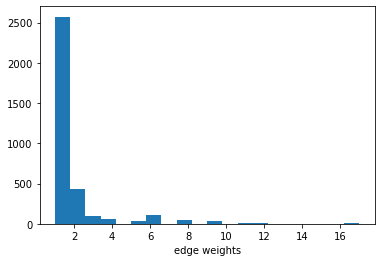

In [299]:
edge_weights = []
for u, v, data in G.edges(data=True):
    edge_weights.append(data['weight'])
    
plt.hist(edge_weights,20)
plt.xlabel('edge weights')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

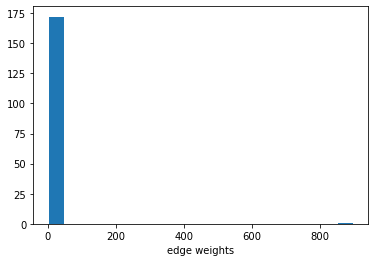

In [300]:
component_sizes = []
for component in nx.connected_components(G):
    component_sizes.append(len(component))
    
    
plt.hist(component_sizes,20)
plt.xlabel('edge weights')
plt.show

In [301]:
for component in nx.connected_components(G):
    print(component, '\n\n\n')

{'Johnny Cash', 'The MG’s', 'Aretha Franklin', 'The Caledonia Soul Express', 'Troye Sivan', 'Morgan Heritage', 'Jerry Garcia', 'Sorocaba', 'Aaron Neville', 'Mose Allison', 'Justin Timberlake', 'Joni Mitchell', 'Lionel Richie', 'Ken Cook', 'Neil', 'Celtic Thunder', 'Shooter Jennings', 'Joe Strummer', 'Dunn', 'Dennis e Matheus', 'Lucinda Williams', 'Molly Tuttle', 'The Bellboys', 'Mary Rodgers', 'The Chieftains', 'Brendon Urie of Panic! at the Disco', 'LaVern Baker', 'Hank Snow', 'T‐Bone Burnett', 'ZAYN', 'Merle Haggard', 'Steely Dan', 'Mark Owen', 'Lou Reed', 'Steve Cradock', 'Anne Murray', 'John Lee Hooker', 'The Raymond Scott Orchestra', 'Luke The Drifter', 'Faye Tucker', 'Mýa', 'Shelley Fabares', 'Taylor Swift', 'S Club 7', 'Boots Randolph', 'The Hawks', 'Kimmie Rhodes', 'Ben Kyle', 'Scott Miller', 'Ne', 'the Comets', 'Doc Watson', 'Chet Atkins', 'Sting', 'Esther Phillips', 'The Nashville Country Singers', 'John Hiatt', 'Ben Sidran', 'Terry Hall', 'Tom Jones', 'Jim Reeves', 'June Car